In [180]:
import h5py
import core.utile as utile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
#toy_file = "debug_counterfactual_means_estimates.h5"
file = "experiment_estimatesvo2_linear.h5"
#file = "toy_estimatesv01.h5"
dataset_info = {}
with h5py.File(file, "r") as f:
    print(f.attrs.keys())
    dataset_info["hyperparameter_names"] = f.attrs["hyperparameter_names"]
    print(f.attrs["hyperparameter_names"])
    dataset_info["grid_of_sample_sizes"] = f.attrs["grid_of_sample_sizes"]
    print(f.attrs["grid_of_sample_sizes"])
    dataset_info["grid_of_intervention_values"] = f.attrs["grid_of_intervention_values"]
    print(f.attrs["grid_of_intervention_values"][:10])

    for hp_name in dataset_info["hyperparameter_names"]:
        dataset_info[hp_name] = f.attrs[hp_name]
    print(f.keys())
    

<KeysViewHDF5 ['B', 'K0', 'a_chip', 'a_force', 'beta', 'd', 'grid_of_intervention_values', 'grid_of_sample_sizes', 'hyperparameter_names', 'm', 'sigma_chip', 'sigma_drift', 'sigma_force', 'xi']>
['d' 'xi' 'K0' 'm' 'beta' 'sigma_force' 'sigma_chip' 'a_chip' 'a_force'
 'sigma_drift']
[  25   50  100  200  400  800 1600 3200 6400]
[216.95366703 218.33605711 219.71844719 221.10083726 222.48322734
 223.86561742 225.2480075  226.63039758 228.01278766 229.39517774]
<KeysViewHDF5 ['d=3.0, xi=0.25, K0=1500.0, m=0.2, beta=0.05, sigma_force=0.1, sigma_chip=0.1, a_chip=0.005, a_force=0.01, sigma_drift=1.0', 'd=3.0, xi=0.25, K0=1500.0, m=0.2, beta=0.05, sigma_force=0.2, sigma_chip=0.2, a_chip=0.005, a_force=0.01, sigma_drift=1.0', 'd=3.0, xi=0.25, K0=1500.0, m=0.2, beta=0.05, sigma_force=0.3, sigma_chip=0.3, a_chip=0.005, a_force=0.01, sigma_drift=1.0', 'd=3.0, xi=0.25, K0=1500.0, m=0.2, beta=0.05, sigma_force=0.4, sigma_chip=0.4, a_chip=0.005, a_force=0.01, sigma_drift=1.0', 'd=3.0, xi=0.25, K0=15

In [186]:
import importlib
importlib.reload(utile)

<module 'core.utile' from 'd:\\users\\emil.bennewitz\\emils_workfiles\\code\\causal_inference\\core\\utile.py'>

# Generic Plotting functions

These functions allow us to calculate all we need to know about the estimator when varying either sample size, intervention value, or sigma = sigma_force = sigma_chip

In [187]:
def _get_statistics(df_estimates, hp_dict, sample_size, intervention_value,lwr_quantile, upr_quantile,filename):
    """
    Returns dict of statistics on the estimates/weights for exactly one hp_combo, one sample size and one intervention value.
    """
    
    keys=["lwr","mean","median","upr","unweighted_lwr","unweighted_mean","unweighted_median","unweighted_upr","true_mean","MSE","bias","variance","unweighted_MSE","unweighted_bias","unweighted_variance","trim"]
    result = {key:None for key in keys}

    with h5py.File(filename,"r") as f:
        intervention_values_grid = f.attrs["grid_of_intervention_values"]
        closest_value_index = np.argmin(np.abs(intervention_values_grid-intervention_value))
        closest_value = intervention_values_grid[closest_value_index]
        hp_key = utile.get_hp_key(filename,hp_dict)
        hp_group=f[hp_key]
        
        result["true_mean"] = hp_group["true_counterfactual_means"][:][closest_value_index]
        weighted_estimates_df = df_estimates[df_estimates["is_weighted"]==1]
        unweighted_estimates_df = df_estimates[df_estimates["is_weighted"]==0]
        
        colname=f"do(Treatment={intervention_value})"
        weighted_column = weighted_estimates_df[colname]
        unweighted_column = unweighted_estimates_df[colname]
        result["mean"] = weighted_column.mean()
        result["median"] = weighted_column.median()
        result["lwr"] = weighted_column.quantile(lwr_quantile)
        result["upr"] = weighted_column.quantile(upr_quantile)
    
        result["unweighted_mean"] = unweighted_column.mean()
        result["unweighted_median"] = unweighted_column.median()
        result["unweighted_lwr"] = unweighted_column.quantile(lwr_quantile)
        result["unweighted_upr"] = unweighted_column.quantile(upr_quantile)

        MSE = np.mean((weighted_column-result["true_mean"])**2)
        bias = np.mean(weighted_column-result["true_mean"])
        variance = np.var(weighted_column)
        assert np.allclose(bias**2+variance, MSE), f"bias**2+variance = {bias**2+variance}, MSE = {MSE}"
        result["MSE"] = MSE
        result["bias"] = bias
        result["variance"] = variance

        result["unweighted_MSE"] = np.mean((unweighted_column-result["true_mean"])**2)
        result["unweighted_bias"] = np.mean(unweighted_column-result["true_mean"])
        result["unweighted_variance"] = np.var(unweighted_column)
        
        result["trim"] = 100*np.mean(weighted_estimates_df["n_trimmed"])/sample_size
    return result

def calculate_statistics(hp_dict, sample_sizes, intervention_value,lwr_quantile = 0.025, upr_quantile = 0.975, filename = file):
    
    if type(sample_sizes) == int:
        sample_sizes = np.array([sample_sizes])
    if type(hp_dict["sigma_force"]) == np.ndarray or type(hp_dict["sigma_chip"]) == np.ndarray:
        assert len(hp_dict["sigma_force"]) == len(hp_dict["sigma_chip"]), "The sigmas for force and chip must have the same length."


    with h5py.File(filename,"r") as f:
        intervention_values_grid = f.attrs["grid_of_intervention_values"]
        sample_sizes_grid = f.attrs["grid_of_sample_sizes"]

    if intervention_value is None:
        intervention_values = intervention_values_grid
    
    else:
        closest_value_index = np.argmin(np.abs(intervention_values_grid-intervention_value))
        closest_value = intervention_values_grid[closest_value_index]
        intervention_values = np.array([closest_value])
    
    if sample_sizes is None:
        sample_sizes = sample_sizes_grid

    
    #Check user input makes sense and identify what it is we must vary
    def check_length(vector_or_number):
        if type(vector_or_number) == np.ndarray:
            return len(vector_or_number)
        elif type(vector_or_number) in [int,float,np.int64,np.float64]:
            return 1
        else:
            raise ValueError("The value must be a number or a numpy array.")
    
    n1 = check_length(hp_dict["sigma_force"])
    n2 = check_length(sample_sizes)
    n3 = check_length(intervention_values)
    
    if n1 != 1:
        print("Varying sigmas")
        quantity_to_vary = "sigmas"
        
        assert n2==1
        assert n3==1
    elif n2 != 1:
        print("Varying sample sizes")
        quantity_to_vary = "sample_sizes"
        assert n1==1
        assert n3==1
    elif n3 != 1:
        print("Varying intervention values")
        quantity_to_vary = "intervention_values"
        assert n1==1
        assert n2==1
    else:
        raise ValueError("You must vary at least one of the following: sigmas, sample sizes, intervention values.")
    
    #Let's go
    n=np.max([n1,n2,n3])
    keys=["lwr","mean","median","upr","unweighted_lwr","unweighted_mean","unweighted_median","unweighted_upr","true_mean","MSE","bias","variance","unweighted_MSE","unweighted_bias","unweighted_variance","trim"]
    results = {key:np.zeros((n,)) for key in keys}
    results["sample_sizes"] = sample_sizes
    results["sigmas"] = hp_dict["sigma_force"]
    results["intervention_values"] = intervention_values
    

    i=0
    d = copy.deepcopy(hp_dict)
    if n1 == 1:
        iterable = [(hp_dict["sigma_force"],hp_dict["sigma_chip"])]
        
    else:
        iterable = zip(hp_dict["sigma_force"],hp_dict["sigma_chip"])
        
    for sigma_force,sigma_chip in iterable:
        d["sigma_force"] = sigma_force
        d["sigma_chip"] = sigma_chip
                
        for sample_size in sample_sizes:
            datasets = utile.get_df_from_hdf5_experiment(filename, hyperparameter_dict=d, sample_size=sample_size, is_endogeneous=True,get_estimates=True)
            df_estimates = datasets["df_estimates"]
            for intervention_value in intervention_values:
                statistics = _get_statistics(df_estimates, d, sample_size, intervention_value,lwr_quantile, upr_quantile,filename = filename)
                for key in keys:
                    results[key][i] = statistics[key]

                i+=1
                
    results["quantity_to_vary"] = quantity_to_vary
    return results

In [188]:
def plot_experiment(results_dict: dict) -> None:
    """
    Plotting the results of the experiment.
    """
    import matplotlib.pyplot as plt
    quantity_to_vary = results_dict["quantity_to_vary"]
    labels={"sample_sizes":"Sample Size",
            "sigmas":"Sigma",
            "intervention_values":"Intervention Value"}

    fig, ax = plt.subplots()
    if quantity_to_vary == "sample_sizes":
        base = 2
        ax.set_xscale("log",base = base)
    #sample_sizes= results_dict["sample_sizes"]
    x_values = results_dict[quantity_to_vary]

    title_addition = ""
    if quantity_to_vary == "sigmas":
        title_addition+=f"n={results_dict['sample_sizes']}"
    if quantity_to_vary == "sample_sizes":
        title_addition+=f"intervention_value={round(results_dict['intervention_values'][0],1)}"
        

    # Plotting the mean and confidence interval on the primary y-axis
    ax.set_title(f"Estimates per {labels[quantity_to_vary]}." + title_addition)
    ax.plot(x_values, results_dict["mean"], label="Mean", color="blue")
    ax.fill_between(x_values, results_dict["lwr"], results_dict["upr"], alpha=0.3, color="blue", label="95% CI")
    ax.plot(x_values,results_dict["true_mean"], color="red", linestyle="--", label="True Mean")
    

    # Set custom tick labels on the x-axis
    if not quantity_to_vary == "intervention_values":
        ax.set_xticks(x_values)  # Explicitly set the tick positions
        ax.set_xticklabels(x_values)  # Use the actual values as tick labels

    #Plot unweighted estimates to see the impact of weighting
    ax.plot(x_values, results_dict["unweighted_mean"], label="Mean (unweighted)", color="indigo")
    ax.fill_between(x_values, results_dict["unweighted_lwr"], results_dict["unweighted_upr"], alpha=0.3, color="indigo", label="95% CI")
    

    # Setting labels and legends for primary y-axis
    ax.set_xlabel(labels[quantity_to_vary])
    ax.set_ylabel("Estimate")
    ax.legend(loc="upper left")

    # Creating a secondary y-axis for the bar chart
    ax2 = ax.twinx()
    if quantity_to_vary == "sample_sizes":
        ax2.bar(x_values, results_dict["trim"], alpha=0.4, color="orange", label="Percentage of Trimmed Weights",width=3.0*(x_values/x_values[0]))
    elif quantity_to_vary == "sigmas":
        ax2.bar(x_values, results_dict["trim"], alpha=0.4, color="orange", label="Percentage of Trimmed Weights", width=0.2*(x_values[1]-x_values[0]))
    # Setting labels and legends for secondary y-axis
    ax2.set_ylabel("Percentage of Trimmed Weights")
    ax2.legend(loc="upper right")

    plt.show()


# Get a dictionary of hyperparameters

In [189]:
example_hp_dict = {}
with h5py.File(file, "r") as f:
    for hp_name in f.attrs["hyperparameter_names"]:
        print("Possible values for ",hp_name, " are : ",f.attrs[hp_name])
        #choose a random value for each hyperparameter
        example_hp_dict[hp_name] = f.attrs[hp_name][0]
        print("Choosing ",f.attrs[hp_name][0], " for ",hp_name)
example_hp_dict["sigma_chip"] = 0.2
example_hp_dict["sigma_force"] = 0.2
    

Possible values for  d  are :  [3. 3. 3. 3. 3.]
Choosing  3.0  for  d
Possible values for  xi  are :  [0.25 0.25 0.25 0.25 0.25]
Choosing  0.25  for  xi
Possible values for  K0  are :  [1500. 1500. 1500. 1500. 1500.]
Choosing  1500.0  for  K0
Possible values for  m  are :  [0.2 0.2 0.2 0.2 0.2]
Choosing  0.2  for  m
Possible values for  beta  are :  [0.05 0.05 0.05 0.05 0.05]
Choosing  0.05  for  beta
Possible values for  sigma_force  are :  [0.1 0.2 0.3 0.4 0.5]
Choosing  0.1  for  sigma_force
Possible values for  sigma_chip  are :  [0.1 0.2 0.3 0.4 0.5]
Choosing  0.1  for  sigma_chip
Possible values for  a_chip  are :  [0.005 0.005 0.005 0.005 0.005]
Choosing  0.005  for  a_chip
Possible values for  a_force  are :  [0.01 0.01 0.01 0.01 0.01]
Choosing  0.01  for  a_force
Possible values for  sigma_drift  are :  [1. 1. 1. 1. 1.]
Choosing  1.0  for  sigma_drift


Quick look at the data

In [190]:
datasets = utile.get_df_from_hdf5_experiment(file, example_hp_dict, 50, is_endogeneous=True,get_estimates=True)
df_data = datasets["df_data"]
df_estimates = datasets["df_estimates"]

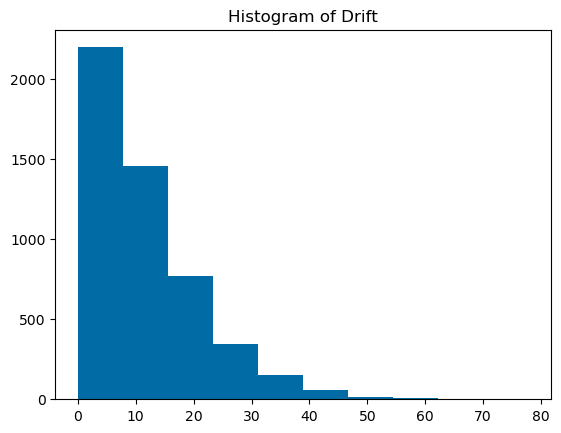

In [191]:
plt.hist(df_data["Drift"])
plt.title("Histogram of Drift")
plt.show()


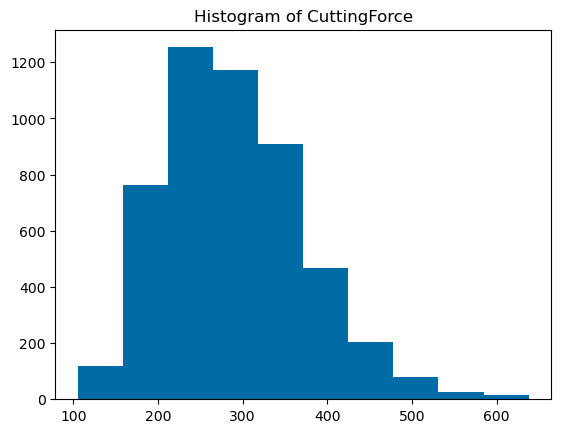

In [192]:
plt.hist(df_data["CuttingForce"])
plt.title("Histogram of CuttingForce")
plt.show()

# How to plot effect of sample size or intervention value

In [193]:
hp_dict = example_hp_dict
hp_dict["sigma_force"] = 0.3
hp_dict["sigma_chip"] = 0.3
print(hp_dict)

{'d': 3.0, 'xi': 0.25, 'K0': 1500.0, 'm': 0.2, 'beta': 0.05, 'sigma_force': 0.3, 'sigma_chip': 0.3, 'a_chip': 0.005, 'a_force': 0.01, 'sigma_drift': 1.0}


Varying sample sizes


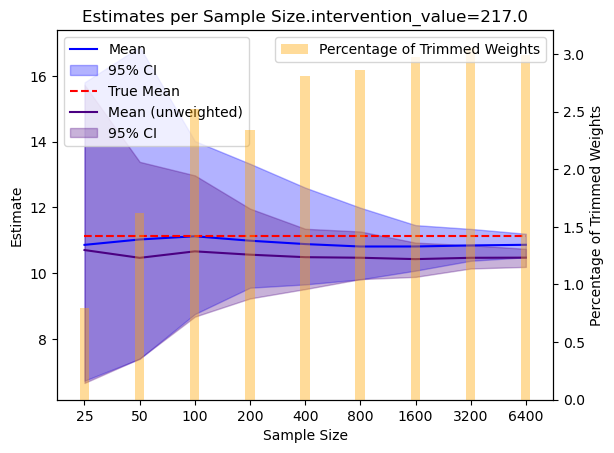

In [194]:
result = calculate_statistics(hp_dict, sample_sizes= None, intervention_value= 180)
plot_experiment(result)

Varying intervention values


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


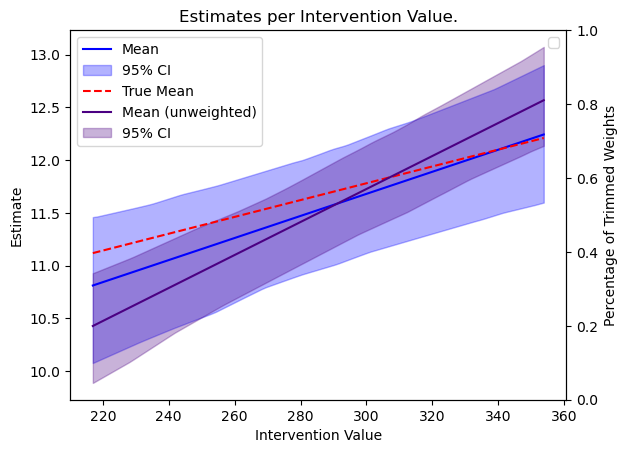

In [195]:
result = calculate_statistics(hp_dict, sample_sizes= 1600, intervention_value= None)
plot_experiment(result)

Varying intervention values


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


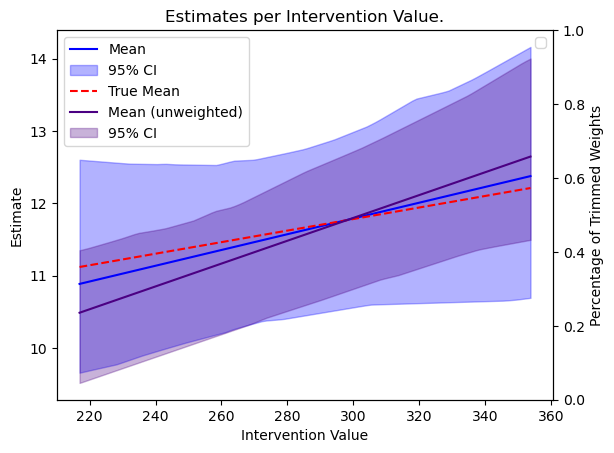

In [196]:
hp_dict["a_force"] = 0.01
result = calculate_statistics(hp_dict, sample_sizes= 400, intervention_value= None)
plot_experiment(result)

# Now visualize effect of noise

In [197]:
sample_size = 200
intervention_value = 250.0
sigmas = np.array([0.1,0.2,0.3,0.4,0.5])
hp_dict = {}
with h5py.File(file, "r") as f:
    for hp_name in f.attrs["hyperparameter_names"]:
        if hp_name not in ["sigma_force","sigma_chip"]:
            print("Possible values for ",hp_name, " are : ",np.unique(f.attrs[hp_name]))
            #choose a random value for each hyperparameter
            hp_dict[hp_name] = f.attrs[hp_name][0]
            print("Choosing ",f.attrs[hp_name][0], " for ",hp_name)
        else:
            hp_dict[hp_name] = sigmas


Possible values for  d  are :  [3.]
Choosing  3.0  for  d
Possible values for  xi  are :  [0.25]
Choosing  0.25  for  xi
Possible values for  K0  are :  [1500.]
Choosing  1500.0  for  K0
Possible values for  m  are :  [0.2]
Choosing  0.2  for  m
Possible values for  beta  are :  [0.05]
Choosing  0.05  for  beta
Possible values for  a_chip  are :  [0.005]
Choosing  0.005  for  a_chip
Possible values for  a_force  are :  [0.01]
Choosing  0.01  for  a_force
Possible values for  sigma_drift  are :  [1.]
Choosing  1.0  for  sigma_drift


Varying sigmas


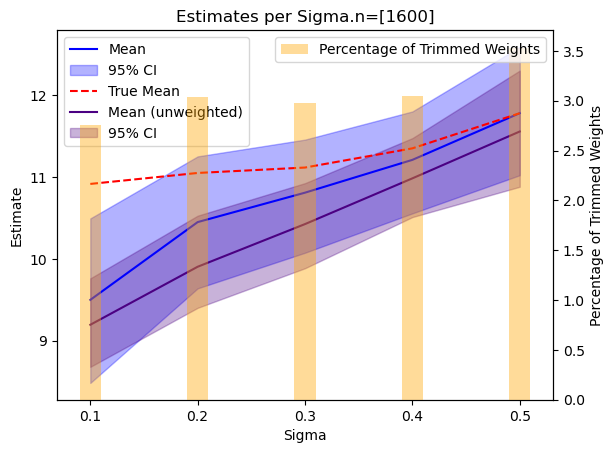

In [198]:
result = calculate_statistics(hp_dict, sample_sizes= 1600, intervention_value= 150)
plot_experiment(result)

In [200]:
hp_dict = {'d': 3.0, 'xi': 0.25, 'K0': 1500.0, 'm': 0.2, 'beta': 0.05, 
'sigma_force': 0.4, 'sigma_chip': 0.4, 'a_chip': 0.005, 'a_force': 0.01, 'sigma_drift': 1.0}

Varying sample sizes


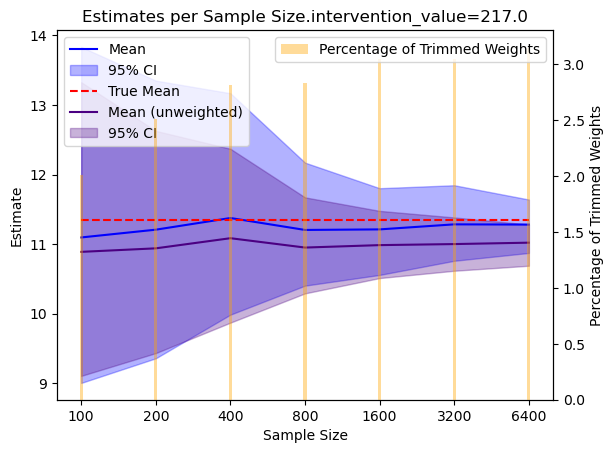

In [201]:
result = calculate_statistics(hp_dict, sample_sizes = np.array([100,200,400,800,1600,3200,6400]), intervention_value = 130)
plot_experiment(result)

# Plot MSE and variance

In [32]:
def plot_MSE(results_dict):
    quantity_to_vary = results_dict["quantity_to_vary"]
    labels={"sample_sizes":"n",
            "sigmas":"Sigma",
            "intervention_values":"x"}
    fig, ax = plt.subplots()
    if quantity_to_vary == "sample_sizes":
        base = 2
        ax.set_xscale("log",base = base)
    #sample_sizes= results_dict["sample_sizes"]
    x_values = results_dict[quantity_to_vary]

    title_addition = ""
    if quantity_to_vary != "sample_sizes":
        title_addition+=f" {labels["sample_sizes"]}={results_dict['sample_sizes']}"
    if quantity_to_vary != "intervention_values":
        title_addition+=f"x = {round(results_dict['intervention_values'][0],1)}"
    if quantity_to_vary != "sigmas":
        title_addition+=f" Sigma = {results_dict['sigmas']}"
    
    # get a colorblind-friendly palette
    plt.style.use('tableau-colorblind10')
    colors = plt.get_cmap("tab10").colors  # "tab10" or "tableau-colorblind10" is colorblind-friendly

    width = 2
    ax.plot(x_values,results_dict["MSE"],color=colors[0], linewidth = width)
    ax.plot(x_values,results_dict["variance"], color= colors[1],linewidth = width)
    ax.plot(x_values,results_dict["bias"]**2,color = colors[2], linewidth = width)

    ax.plot(x_values,results_dict["unweighted_MSE"],color=colors[0],linestyle="-.", linewidth = width)
    ax.plot(x_values,results_dict["unweighted_variance"], color= colors[1],linestyle="-.", linewidth = width)
    ax.plot(x_values,results_dict["unweighted_bias"]**2,color = colors[2],linestyle="-.", linewidth = width)

    #add a grid
    ax.grid(True)
    
    # Set custom tick labels on the x-axis
    if not quantity_to_vary == "intervention_values":
        ax.set_xticks(x_values)  # Explicitly set the tick positions
        ax.set_xticklabels(x_values)  # Use the actual values as tick labels


    ax.set_title(f"MSE, Bias and Variance depending on {labels[quantity_to_vary]}. " + title_addition)
    ax.set_xlabel(quantity_to_vary)
    ax.set_ylabel("Value")
    ax.legend(["IPW MSE","IPW Variance","IPW Bias^2","Unweighted MSE","Unweighted Variance","Unweighted Bias^2"])
    plt.show()


Varying intervention values


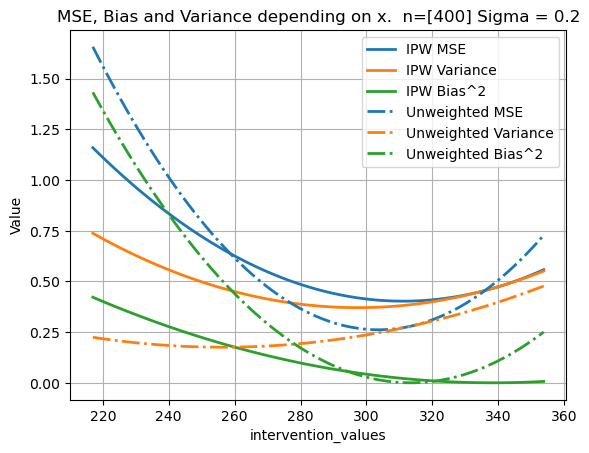

In [18]:
hp_dict = {'d': 3.0, 'xi': 0.25, 'K0': 1500.0, 'm': 0.2, 'beta': 0.05, 
'sigma_force': 0.2, 'sigma_chip': 0.2, 'a_chip': 0.005, 'a_force': 0.01, 'sigma_drift': 1.0}
#print(dataset_info)
result=calculate_statistics(hp_dict, sample_sizes = 400, intervention_value = None)
plot_MSE(result)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


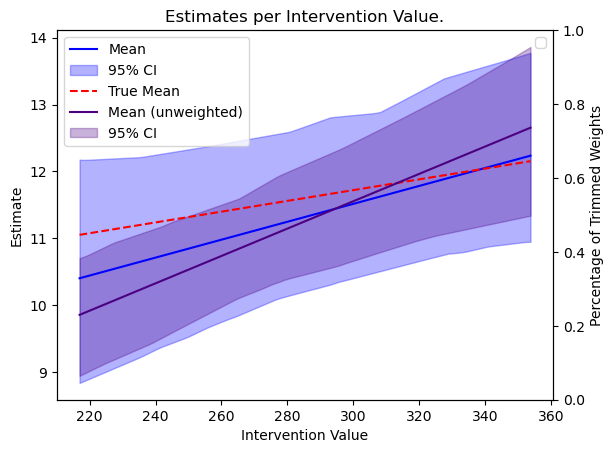

In [19]:
plot_experiment(result)

In [20]:
print(result.keys())

dict_keys(['lwr', 'mean', 'median', 'upr', 'unweighted_lwr', 'unweighted_mean', 'unweighted_median', 'unweighted_upr', 'true_mean', 'MSE', 'bias', 'variance', 'unweighted_MSE', 'unweighted_bias', 'unweighted_variance', 'trim', 'sample_sizes', 'sigmas', 'intervention_values', 'quantity_to_vary'])


# Diagnostics

Build a function to check for overlap

In [162]:
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as grid_spec
from itertools import cycle

def _check_overlap(df_data,GPS_matrix, grid_of_intervention_values):
    batch_size,n_batches = GPS_matrix.shape
    treatment = df_data["CuttingForce"]
    assert n_batches == df_data["batchnr"].max()+1, "Sanity check: The number of batches in the GPS matrix must be equal to the number of batches in the data."
    n_bins=10
    quantiles = np.quantile(treatment, np.linspace(0,1,n_bins+1))
    GPS_raveled = GPS_matrix.reshape(-1,order = "F") #C style order, the default, flattens by stacking one row below the other. We want one column after the other as





    fig = plt.figure(figsize=(12,8))
    gs = (grid_spec.GridSpec(n_bins,1))
    ax_objs = []
    colors = cycle(['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00', '#984EA3', '#FF00FF', '#FFFF33', '#A65628', '#F781BF', '#999999'])

    labels = [f"Bin {i+1}" for i in range(n_bins)]
    max_histogram_value = 0
    for i in range(n_bins):

        #Create the mask indicating which datapoints are in the bin i.
        lower_bound = quantiles[i]
        upper_bound = quantiles[i+1]
        mask = (treatment >= lower_bound) & (treatment < upper_bound)
        if i == n_bins-1:
            mask = (treatment >= lower_bound) & (treatment <= upper_bound)
        
        print(f"Bin {i+1} has : {np.sum(mask)} datapoints.")
        assert np.all(GPS_raveled[i*batch_size:(i+1)*batch_size] == GPS_matrix[:,i]), "Sanity check: The raveled GPS matrix must be stacking columns."
        
        #Do a ridge plot
        color = next(colors)
        ax_objs.append(fig.add_subplot(gs[i,0]))
        kde = stats.gaussian_kde(GPS_raveled[mask])
        kde.set_bandwidth(bw_method='silverman')
        grid_of_scores = np.linspace(np.min(GPS_matrix),np.max(GPS_matrix),100)
        kde_values = kde(grid_of_scores)
        ax= ax_objs[i]
        label = f"Treatment in [{round(lower_bound,0)},{round(upper_bound,0)}]"
        hist = True
        if not hist:
            ax.plot(grid_of_scores, kde_values,color = color,label = label)
            ax.fill_between(grid_of_scores, kde_values, alpha = 0.3, color = color)
        else:
            densities,bins,patches = ax.hist(GPS_raveled[mask], bins = 20, density = True, alpha = 0.3, color = color, label=label)
            
        if np.max(densities) > max_histogram_value:
            max_histogram_value = np.max(densities)
        
        ax.set_xlim(GPS_matrix.min(),GPS_matrix.max())
        directions = ["top","right","bottom"]
        for d in directions:
            ax.spines[d].set_visible(False)
        ax.patch.set_alpha(0) #Transparent background, this is the magic
        ax.set_ylabel("")
        ax.set_yticks([])
        ax.set_xticks([])
        #ax.text(0.1,0.2,f"Treatment in [{round(lower_bound,0)},{round(upper_bound,0)}]",transform=ax.transAxes,rotation=0,fontsize=12)
    gs.update(hspace=-0.5)
    ax_objs[-1].set_xlabel("Generalised Propensity Score", fontsize=16)
    ax_objs[-1].set_xticks(np.linspace(GPS_matrix.min(),GPS_matrix.max(),10))
    ax_objs[-1].spines["bottom"].set_visible(True)

    for ax in ax_objs:
        ax.set_ylim(0,max_histogram_value)
        
    #Set title
    fig.suptitle("KDE of GPS for each treatment value bin", fontsize=16)
    fig.supylabel("Density", fontsize=16)
    fig.legend(loc="upper right")
    fig.show()


def calculate_diagnostics(hp_dict, sample_size, grid_of_intervention_values, filename):
    datasets = utile.get_df_from_hdf5_experiment(filename, hp_dict, sample_size, is_endogeneous=True,get_estimates=True)
    df_data = datasets["df_data"]
    df_estimates = datasets["df_estimates"]
    GPS_matrix = datasets["f_A_given_Z"]
    _check_overlap(df_data=df_data,GPS_matrix=GPS_matrix, grid_of_intervention_values=grid_of_intervention_values)


In [163]:
import importlib
importlib.reload(utile)

<module 'core.utile' from 'd:\\users\\emil.bennewitz\\emils_workfiles\\code\\causal_inference\\core\\utile.py'>

Bin 1 has : 400 datapoints.
Bin 2 has : 400 datapoints.
Bin 3 has : 400 datapoints.
Bin 4 has : 400 datapoints.
Bin 5 has : 400 datapoints.
Bin 6 has : 400 datapoints.
Bin 7 has : 400 datapoints.
Bin 8 has : 400 datapoints.
Bin 9 has : 400 datapoints.
Bin 10 has : 400 datapoints.


D:\Users\Emil.Bennewitz\AppData\Local\Temp\ipykernel_12852\2254436755.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


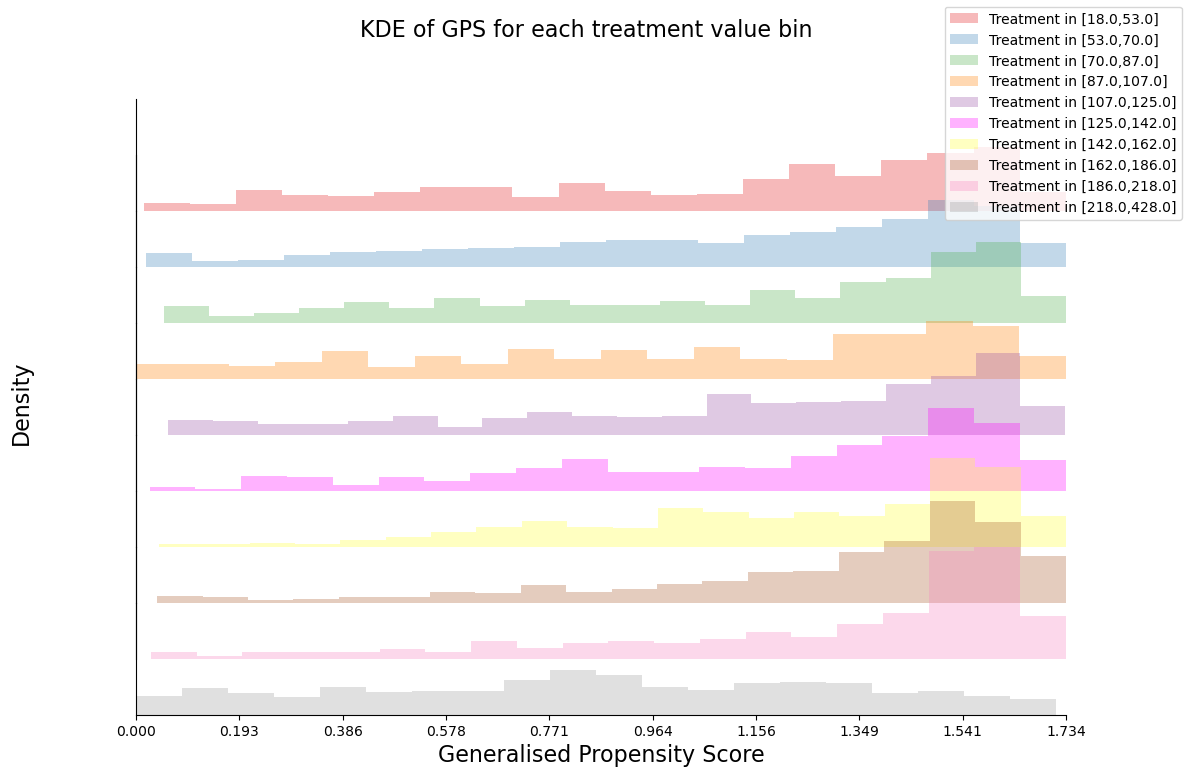

In [164]:
hp_dict = {'d': 5.0, 'xi': 0.25, 'K0': 1500.0, 'm': 0.3, 'beta': 0.05, 
'sigma_force': 0.25, 'sigma_chip': 0.25, 'a_chip': 0.005, 'a_force': 0.02, 'sigma_drift': 1.0}
calculate_diagnostics(hp_dict, sample_size = 400, grid_of_intervention_values = dataset_info["grid_of_intervention_values"], filename = file)

This graph can help diagnose vilations of positivity. That doesn't seem too bad here.

In [51]:
with h5py.File(file, "r") as f:
    hp_group = f[utile.get_hp_key(file,hp_dict)]
    n_group = hp_group["n_400"]
    group = n_group["endogeneous_f_A_given_Z"]
    name = group.name
    GPS_matrix = group[:]
    print(GPS_matrix.shape)
    print(name)
    print(group)

(400, 10)
/d=5.0, xi=0.25, K0=1500.0, m=0.3, beta=0.05, sigma_force=0.25, sigma_chip=0.25, a_chip=0.005, a_force=0.02, sigma_drift=1.0/n_400/endogeneous_f_A_given_Z
<HDF5 dataset "endogeneous_f_A_given_Z": shape (400, 10), type "<f8">


In [172]:
A= np.arange(15)
np.array_split(A,4)
B= np.full((5,),np.nan)
print(B)

[nan nan nan nan nan]
